In [73]:
import pandas as pd
from datetime import datetime
import ast
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [74]:
PATH = 'src'

In [75]:
header = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie name', 'Movie release date', 'Movie box office revenue', 'Movie runtime', 
          'Movie languages', 'Movie country', 'Movie genres']
df = pd.read_csv(PATH + '/movie.metadata.tsv', sep='\t', names=header, skipinitialspace=True)


In [76]:
df.head(5)

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie country,Movie genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


### Cleaning df1

In [77]:
print("data set initial size = ", df.size)

data set initial size =  735669


In [78]:
df.isnull().values.any()

True

In [79]:
df.isnull().sum()

Wikipedia movie ID              0
Freebase movie ID               0
Movie name                      0
Movie release date           6902
Movie box office revenue    73340
Movie runtime               20450
Movie languages                 0
Movie country                   0
Movie genres                    0
dtype: int64

In [80]:

df = df[(df['Movie country'] != "{}") & (df['Movie languages'] != "{}") & (df['Movie genres'] != "{}")]
print(df.size)

576792


In [81]:
df['Movie country'] = df['Movie country'].apply(lambda x: list(ast.literal_eval(x).values())[0])
df['Movie genres'] = df['Movie genres'].apply(lambda x: list(ast.literal_eval(x).values()))
df['Movie languages'] = df['Movie languages'].apply(lambda x: list(ast.literal_eval(x).values()))

In [82]:
df.sample(10)


,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie country,Movie genres
45454,8129295,/m/026sp14,Odette,1960-06-06,NaN,124.0,"[French Language, German Language, English Lan...",United Kingdom,"[War film, Drama, Black-and-white, Spy]"
44484,8220647,/m/026wn96,Desh Premee,1982-04-23,NaN,120.0,[Hindi Language],India,"[Drama, Political drama, World cinema]"
49730,35939219,/m/0jwvrnk,The Robber Bride,1916-09-29,NaN,NaN,"[Silent film, German Language]",Germany,"[Short Film, Silent film, Comedy film]"
30230,238810,/m/01jmyj,Air Force One,1997-07-25,315156409.0,125.0,"[English Language, Russian Language]",United States of America,"[Thriller, Action Thrillers, Short Film, Actio..."
25051,27581632,/m/0c3_p6z,Pappa polis,2002-11,NaN,76.0,[Swedish Language],Sweden,[Family Drama]
15288,17015110,/m/0k934sz,The Wild Weird World of Dr. Goldfoot,1965-11-18,NaN,30.0,[English Language],United States of America,"[Short Film, Comedy film]"
70345,17759441,/m/0479t9h,Troublesome Night 4,1998-08-25,NaN,97.0,[Cantonese],Hong Kong,"[Horror, Chinese Movies]"
43243,909947,/m/03p0l5,Casualties of Love: The Long Island Lolita Story,1993-01-03,NaN,95.0,[English Language],United States of America,"[Crime Fiction, Romance Film, Drama]"
2477,5720474,/m/0f11xf,"Franco, ese hombre",1964,NaN,103.0,[Spanish Language],Spain,[Documentary]
37631,21038494,/m/05b2fhq,Thedi Vandha Mappillai,1970,NaN,157.0,[Tamil Language],India,"[Musical, Drama, Bollywood, World cinema]"


In [83]:
df_date_revenue_clean = df.dropna(subset=['Movie release date', 'Movie box office revenue'])
df_date_clean = df.dropna(subset=['Movie release date'])
df_date_revenue_runtime_clean = df.dropna(subset=['Movie release date', 'Movie box office revenue', 'Movie runtime'])


#formating dates
def format_date(date) :
    date = date[:4]
    return date

df_date_revenue_clean['Movie release date'] = df_date_revenue_clean['Movie release date'].apply(format_date)
df_date_clean['Movie release date'] = df_date_clean['Movie release date'].apply(format_date)
df_date_revenue_runtime_clean['Movie release date'] = df_date_revenue_runtime_clean['Movie release date'].apply(format_date)



/var/folders/_p/nx4vm0x94g52cgnydl3lw1x00000gn/T/ipykernel_16474/35622789.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_date_revenue_clean['Movie release date'] = df_date_revenue_clean['Movie release date'].apply(format_date)
/var/folders/_p/nx4vm0x94g52cgnydl3lw1x00000gn/T/ipykernel_16474/35622789.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_date_clean['Movie release date'] = df_date_clean['Movie release date'].apply(format_date)
/var/folders/_p/nx4vm0x94g52cgnydl3lw1x00000gn/T/ipykern

In [84]:
print('Size of the data with the dates cleaned up : ', df_date_clean.size)
print('Size of the data with the dates and the box office revenues cleaned up : ', df_date_revenue_clean.size)
print('Size of the data with the dates, the box office revenues and the runtimes cleaned up : ', df_date_revenue_runtime_clean.size)

Size of the data with the dates cleaned up :  555507
Size of the data with the dates and the box office revenues cleaned up :  72207
Size of the data with the dates, the box office revenues and the runtimes cleaned up :  71838


We can see that when we clean the rows that do not contain values of boow offic revenue the dataset is seriously reduced. The idea here is to keep a version of the dataset without taking care of the box office revenue when it is not the target of the analysis. We notice that the size difference between  df_date_revenue_clean and df_date_revenue_runtime_clean is negligeable, no need to treat them separately.

In [85]:

df_date_revenue_runtime_clean.sample(10)

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie country,Movie genres
67795,13114104,/m/02z72bt,The Uninvited,2009,41624046.0,87.0,[English Language],United States of America,"[Thriller, Horror, Supernatural, Psychological..."
19836,9459932,/m/0289qqx,Allegheny Uprising,1939,750000.0,81.0,[English Language],United States of America,"[Action/Adventure, Costume drama, Western, Act..."
39792,3880325,/m/0b4sr7,Father's Little Dividend,1951,3100000.0,82.0,[English Language],United States of America,"[Romance Film, Comedy, Domestic Comedy]"
67153,24355152,/m/07s3dyq,Joysticks,1983,3952448.0,83.0,[English Language],United States of America,"[Comedy, Indie]"
10118,20109381,/m/0crtrnm,Voices,2007,1760707.0,84.0,[Korean Language],South Korea,"[Horror, Slasher, World cinema]"
63116,2274938,/m/07022t,Friday the 13th Part 2,1981,22722776.0,86.0,[English Language],United States of America,"[Cult, Horror, Slasher, Teen]"
21353,2997355,/m/08jl3y,It Could Happen to You,1994,37939757.0,101.0,[English Language],United States of America,"[Romantic comedy, Drama, Romance Film, Comedy-..."
37965,3948455,/m/0b84rz,Universal Soldier,1992,102299898.0,84.0,[English Language],United States of America,"[Science Fiction, Indie, Action/Adventure, Mar..."
41114,26508187,/m/0bh95g3,Drive Angry,2011,28931401.0,105.0,[English Language],United States of America,"[Thriller, Action Thrillers, Supernatural, Cha..."
53902,3874380,/m/0b4gnw,Dragnet,1987,66673516.0,106.0,[English Language],United States of America,"[Parody, Action/Adventure, Action, Comedy]"


In [86]:
df_date_revenue_clean.sample(10)

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie country,Movie genres
39667,1591891,/m/05d_vs,The Mating Season,1951,1625000.0,101.0,[English Language],United States of America,"[Romantic comedy, Romance Film, Screwball come..."
53394,518687,/m/02ktq2,The Raven,1963,1499275.0,85.0,[English Language],United States of America,"[Costume drama, Horror, B-movie, Comedy]"
66330,717281,/m/035cvl,Pandora and the Flying Dutchman,1951,1250000.0,123.0,"[English Language, Spanish Language]",United Kingdom,"[Mystery, Period piece, Fantasy, Drama, Romant..."
45504,35991931,/m/0b4cpzy,The Girl Rush,1955,1000000.0,85.0,[English Language],United States of America,"[Musical, Comedy film]"
24577,3247979,/m/0913gc,The Great Waldo Pepper,1975,20642922.0,107.0,[English Language],United States of America,"[Adventure, Americana, Action/Adventure, Perio..."
13883,1411408,/m/04_ccy,Shadows and Fog,1992,2735731.0,85.0,[English Language],United States of America,"[Thriller, Indie, Comedy Thriller, Mystery, Co..."
56028,171623,/m/01718w,Training Day,2001,104876233.0,122.0,"[Russian Language, English Language, Standard ...",United States of America,"[Crime Fiction, Crime Thriller, Drama, Adventu..."
37224,8575331,/m/0278j53,Mortal Thoughts,1991,19018321.0,102.0,[English Language],United States of America,"[Thriller, Mystery, Marriage Drama, Psychologi..."
33471,12687445,/m/02x0j27,Swing Vote,2008,17634313.0,119.0,[English Language],United States of America,"[Political cinema, Drama, Comedy-drama, Comedy]"
69086,44501,/m/0c3z0,Cast Away,2000,429632142.0,143.0,"[English Language, Russian Language]",United States of America,"[Action/Adventure, Drama, Adventure, Airplanes..."


In [87]:
header2 = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie release date','Character Name', 'Actor DOB', 'Actor gender',
           'Actor height', 'Actor ethnicity', 'Actor name', 'Actor age at movie release', 'Freebase character map']
df2 = pd.read_csv(PATH + '/character.metadata.tsv', sep='\t', index_col=False, names=header2, skipinitialspace=True)

/var/folders/_p/nx4vm0x94g52cgnydl3lw1x00000gn/T/ipykernel_16474/2071516340.py:3: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df2 = pd.read_csv(PATH + '/character.metadata.tsv', sep='\t', index_col=False, names=header2, skipinitialspace=True)


In [88]:
df2.head(5)

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character Name,Actor DOB,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age at movie release,Freebase character map
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r


In [89]:
df2.isnull().values.any()

True

In [90]:
df2.isnull().sum()

Wikipedia movie ID                 0
Freebase movie ID                  0
Movie release date              9995
Character Name                257875
Actor DOB                     106145
Actor gender                   45609
Actor height                  295845
Actor ethnicity               344611
Actor name                      1228
Actor age at movie release    158113
Freebase character map             0
dtype: int64

In [91]:
merged_df = pd.merge(df, df2, on='Wikipedia movie ID', how='inner')

merged_df = merged_df.drop(columns=['Freebase movie ID_y', 'Movie release date_y'])

merged_df = merged_df.rename(columns={'Freebase movie ID_x': 'Freebase movie ID', 
                                      'Movie release date_x': 'Movie release date'})


In [92]:
merged_df.head(5)

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie country,Movie genres,Character Name,Actor DOB,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age at movie release,Freebase character map
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],United States of America,"[Thriller, Science Fiction, Horror, Adventure,...",Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],United States of America,"[Thriller, Science Fiction, Horror, Adventure,...",Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m
2,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],United States of America,"[Thriller, Science Fiction, Horror, Adventure,...",Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g
3,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],United States of America,"[Thriller, Science Fiction, Horror, Adventure,...",Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6
4,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],United States of America,"[Thriller, Science Fiction, Horror, Adventure,...",Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r


In [93]:
merged_df.isnull().values.any()

True

In [94]:
merged_df.isnull().sum()

Wikipedia movie ID                 0
Freebase movie ID                  0
Movie name                         0
Movie release date              4646
Movie box office revenue      309289
Movie runtime                  36529
Movie languages                    0
Movie country                      0
Movie genres                       0
Character Name                224626
Actor DOB                      97865
Actor gender                   41680
Actor height                  267460
Actor ethnicity               312605
Actor name                      1108
Actor age at movie release    140287
Freebase character map             0
dtype: int64

In [95]:
count = 0
for i in range (len(merged_df)):
    if merged_df.iloc[i].duplicated().all():
        count+=1

print("Nb of duplicated row : ",count)

Nb of duplicated row :  0


In [96]:

# Supprimer les valeurs NaN de la colonne 'Movie release date'
merged_df = merged_df.dropna(subset=['Movie release date'])

# Fonction pour compléter les dates partiellement formatées
def complete_date(date):
    if len(date) == 4:  # Si la date contient seulement l'année (format '%Y')
        return date + "-01-01"  # Compléter avec le 1er janvier de l'année
    elif len(date) == 7:  # Si la date contient l'année et le mois (format '%Y-%m')
        return date + "-01"  # Compléter avec le 1er jour du mois
    return date  # Si la date est déjà complète (format '%Y-%m-%d')

# Appliquer la fonction pour compléter les dates partiellement formatées
merged_df['Movie release date'] = merged_df['Movie release date'].apply(complete_date)

# Filtrer les dates qui sont en dehors de la plage valide (1677-2262)
def filter_out_of_bounds(date):
    try:
        # Tenter la conversion en datetime pour voir si elle est valide
        pd.to_datetime(date)
        return True  # Si la conversion réussit, la date est valide
    except pd.errors.OutOfBoundsDatetime:
        return False  # Si une erreur est levée, la date est hors limites

# Appliquer le filtre pour garder uniquement les dates dans la plage valide
merged_df = merged_df[merged_df['Movie release date'].apply(filter_out_of_bounds)]

# Convertir les dates restantes en format datetime
merged_df['Movie release date'] = pd.to_datetime(merged_df['Movie release date'], format='%Y-%m-%d', errors='coerce')

min_date = merged_df['Movie release date'].min()
max_date = merged_df['Movie release date'].max()

print(min_date)
print(max_date)

1888-01-01 00:00:00
2015-01-01 00:00:00


# Data Analysis

### 1) Dataset Exploration

In [97]:
df_date_clean.describe()

,Wikipedia movie ID,Movie box office revenue,Movie runtime
count,6.172300e+04,8.023000e+03,5.088400e+04
mean,1.539445e+07,4.964490e+07,1.161865e+02
std,1.067145e+07,1.141051e+08,4.784577e+03
min,3.300000e+02,1.000000e+04,0.000000e+00
25%,5.698346e+06,2.249000e+06,8.300000e+01
50%,1.399171e+07,1.144980e+07,9.400000e+01
75%,2.405106e+07,4.304346e+07,1.070000e+02
max,3.750192e+07,2.782275e+09,1.079281e+06


In this analysis, we focus on the first 18 countries which produce the more movies

['United States of America', 'India', 'United Kingdom', 'France', 'Japan', 'Italy', 'Argentina', 'Canada', 'Germany', 'Hong Kong', 'Mexico', 'Australia', 'South Korea', 'Spain', 'Russia', 'Netherlands', 'Denmark', 'Sweden']


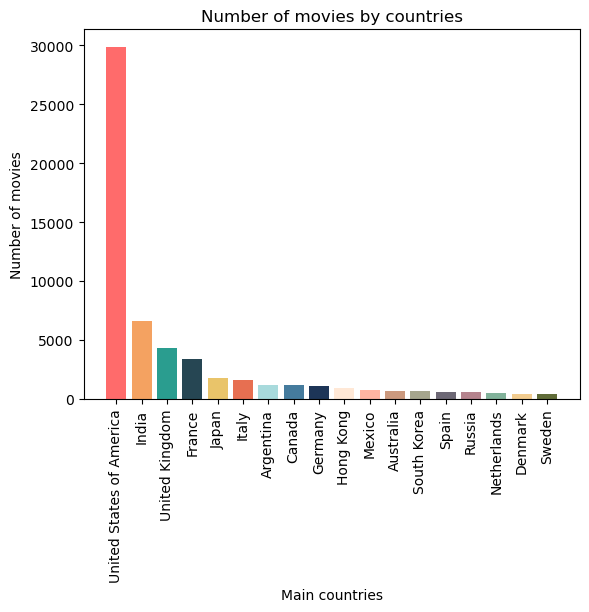

In [98]:
countries = df_date_clean.groupby(['Movie country']).count()['Wikipedia movie ID']

countries['Russia'] = countries['Russia'] + countries['Soviet Union']
countries['Germany'] = countries['Germany'] + countries['German Democratic Republic'] + countries['West Germany']
countries = countries.drop('Soviet Union')
countries = countries.nlargest(18)
countries_names = countries.index.to_list()

colors = [
    "#FF6B6B", "#F4A261", "#2A9D8F", "#264653", "#E9C46A", "#E76F51", "#A8DADC", "#457B9D", "#1D3557", "#FFE8D6", 
    "#FFB4A2",  
    "#CB997E",  
    "#A5A58D",  
    "#6D6875",  
    "#B5838D",  
    "#81B29A",  
    "#F2CC8F",  
    "#606C38" 
]


plt.bar(countries_names,countries,width=0.8, color = colors)
plt.xticks(rotation=90)
plt.xlabel('Main countries')
plt.ylabel('Number of movies')
plt.title('Number of movies by countries')
plt.show()

['United States of America', 'India', 'United Kingdom', 'France', 'Japan', 'Italy', 'Argentina', 'Canada', 'Germany', 'Hong Kong', 'Mexico', 'Australia', 'South Korea', 'Spain', 'Russia', 'Netherlands', 'Denmark', 'Sweden']


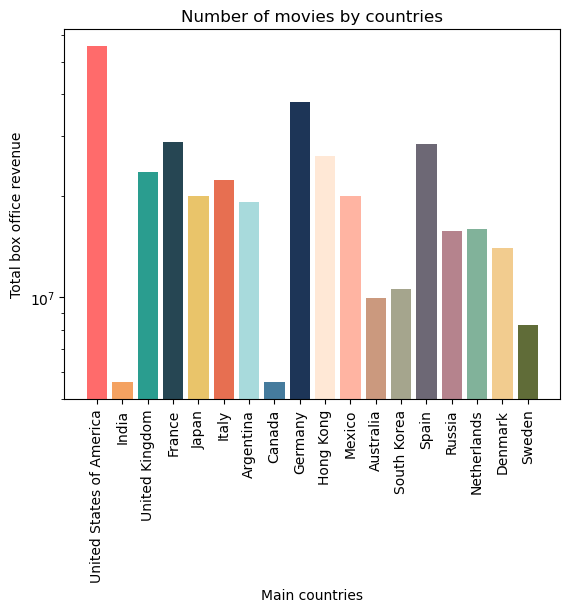

In [99]:
countries_revenues = df_date_revenue_clean.groupby(['Movie country'])['Movie box office revenue'].mean()
countries_revenues['Germany'] = (countries_revenues['Germany'] + countries_revenues['West Germany'])/2
countries_revenues = countries_revenues.drop('West Germany')
countries_revenues = countries_revenues[countries_names]



plt.bar(countries_names, countries_revenues, color = colors)
plt.yscale('log')
plt.xticks(rotation=90)
plt.xlabel('Main countries')
plt.ylabel('Total box office revenue')
plt.title('Number of movies by countries')
plt.show()

In this section, we will focus on the 4 biggest film producers and analyse their movie production over the years, starting from 1890 to 2016.

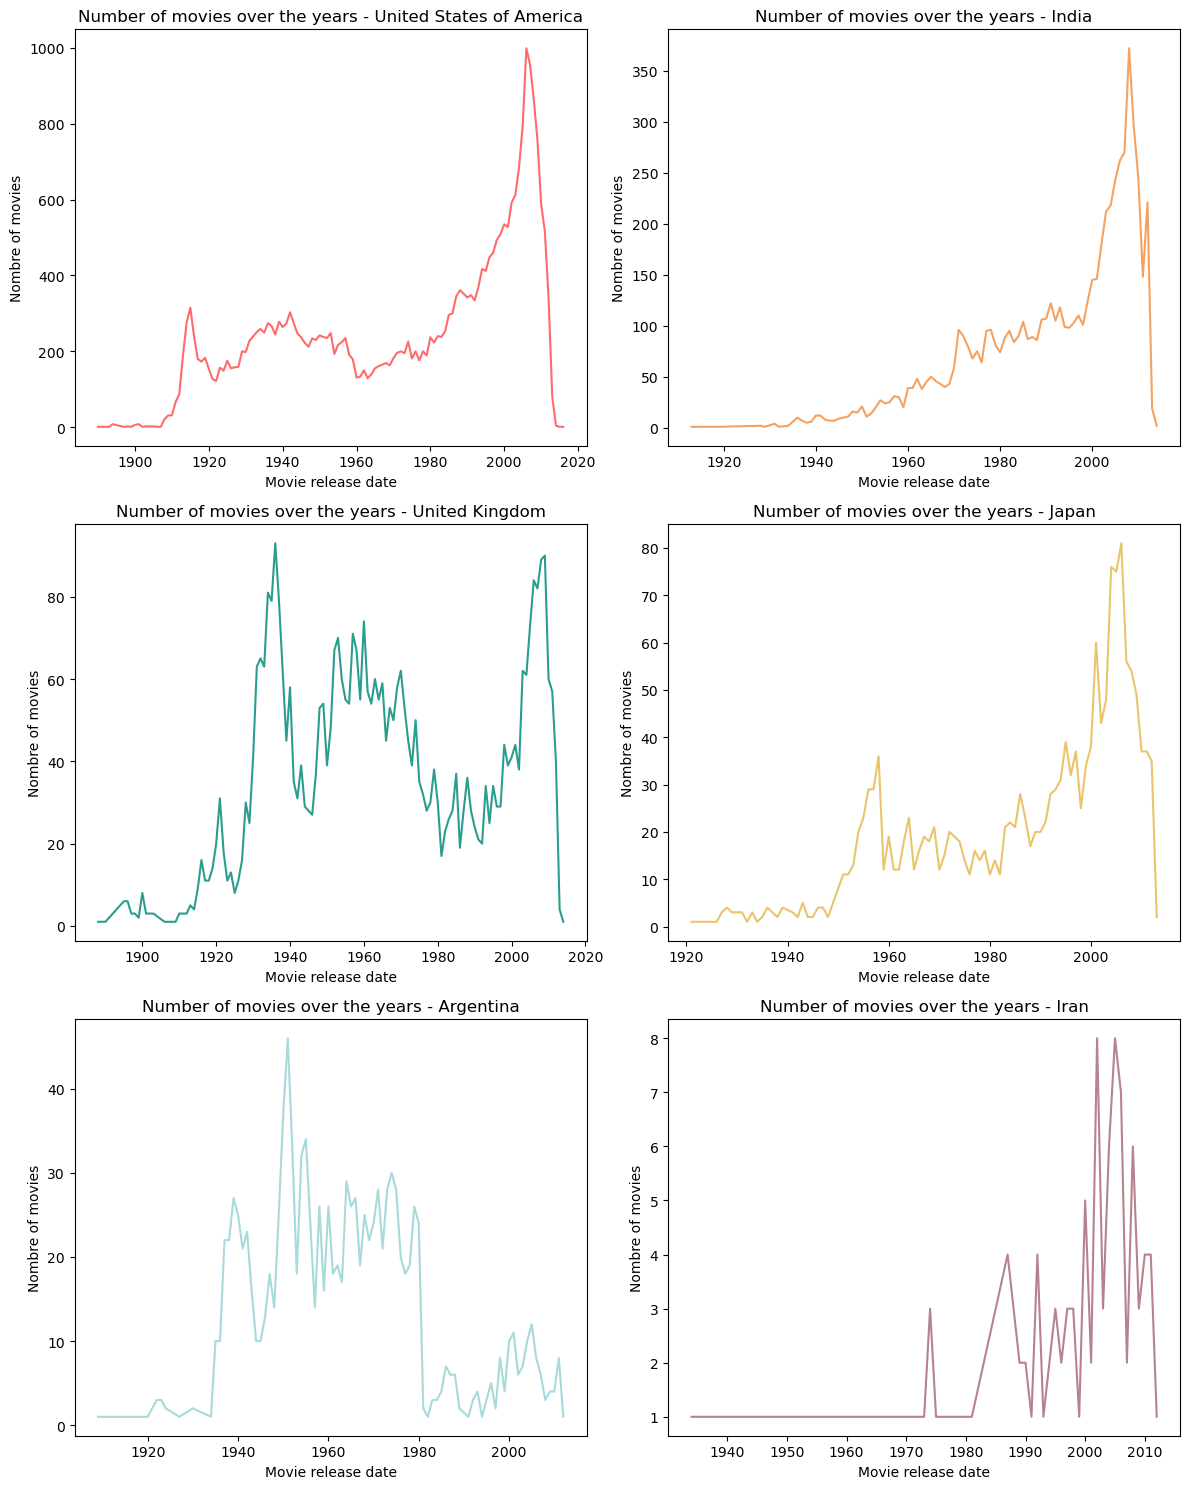

In [102]:
focus_countries = ['United States of America', 'India', 'United Kingdom', 'Japan', 'Argentina', 'Iran']
colors = ['#FF6B6B', '#F4A261', '#2A9D8F', '#E9C46A', '#A8DADC', '#B5838D']

df_focus = df_date_clean[df_date_clean['Movie country'].isin(focus_countries)]

nb_per_year = df_focus.groupby(['Movie country', 'Movie release date']).count()['Wikipedia movie ID']
nb_per_year = nb_per_year.reset_index()
nb_per_year = nb_per_year.rename(columns={'Wikipedia movie ID': 'Movie count'})

nb_per_year['Movie release date'] = pd.to_datetime(nb_per_year['Movie release date'], errors='coerce')

num_columns = 2
num_rows = 3
fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, 15))
axes = axes.flatten()

for idx, country in enumerate(focus_countries):
    country_data = nb_per_year[nb_per_year['Movie country'] == country]
    
    axes[idx].plot(country_data['Movie release date'], country_data['Movie count'], linestyle='-', color=colors[idx])
    axes[idx].set_title(f"Number of movies over the years - {country}")
    axes[idx].set_xlabel("Movie release date")
    axes[idx].set_ylabel("Nombre of movies")

plt.tight_layout()
plt.show()

The global trend that we see on the 6 graphs is an increase of the movie production between 1890 and 2007. We can interprate those result and estimate that the advancement of new technologies worldwide are the major cause of this increase.

We can observe a drop in the american movie production around 1915 which coincides with World War I. It did not really affected the UK because their movie production was very low at that time. India, Argentina, Iran and Japan was not involved in World War I. Concerning World War II the observation is a bit different. We notice a huge decrease of number of movie for the UK and Argentina around 1939-1945 and a less important one for the USA. UK and USA were directly involved in the World War II while Argentina had the influence of Germany and Italy. Moreover, the number of movies produced per yer before 1940 for Japan is very low but we can observe that this number increases a lot after World War II. 

Around 2007, we discern a fall of prodcution for the 6 countries. This date corresponds to the appearance of Netflix, a platform that offers a streaming service of movies, series. People can access to huge number of movies very easily without having to go to cinema theatres. 2008 economic crisis could also have an impact on this production of movies.

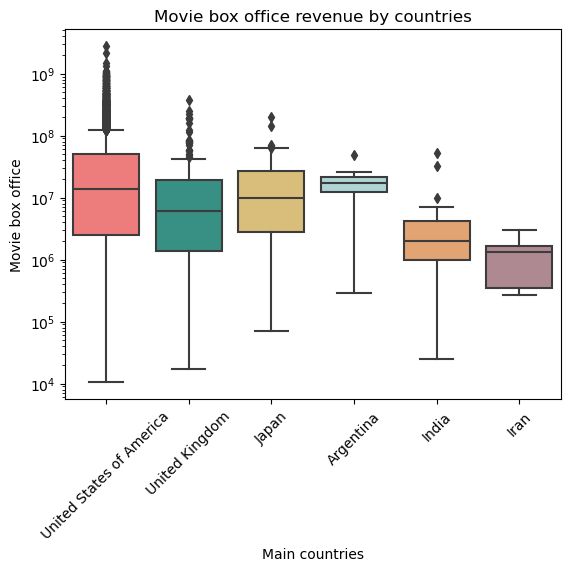

In [103]:
df_revenue_focus = df_date_revenue_clean[df_date_revenue_clean['Movie country'].isin(focus_countries)]

countries_revenues = df_revenue_focus.groupby(['Movie country'])['Movie box office revenue']

color_dict = dict(zip(focus_countries, colors))
sns.boxplot(x='Movie country', y='Movie box office revenue', data=df_revenue_focus, palette=color_dict)
plt.yscale('log')
plt.xticks(rotation=45)
plt.xlabel('Main countries')
plt.ylabel('Movie box office')
plt.title('Movie box office revenue by countries')
plt.show()

India is the second country with the highest number of films produced however the boxplot shows that the movie box office revenue per film is lower than UK, Japan or Argentina even if these countries produce less films. 

USA is still the first country and there are a lot of outliers with a high movie box office revenue. 

Argentina is the 7 country with the highest nb of films produced, after USA, India, UK and Japan. However, we can observe that in mean, it has a highest movie box office revenue per film than these countries. It also has a lower difference between first and third quartile. However it has just one outliers with a abnormaly high movie box office revenue. 

Iran is the country with the lowest number of film produced and also, in average, the lowest movie box office revenue. Nonetheless, it has the lowest gap between whiskers meaning that the distribution of the box office revenue per film is consistent.

# Correlation

               Movie country  Total Movie Count
0                Afghanistan                  1
1                  Argentina                  7
2                  Australia                 57
3                    Austria                  5
4                    Belgium                  7
5                     Brazil                  5
6                   Bulgaria                  1
7                     Canada                 67
8                      China                  9
9             Czech Republic                  5
10                   Denmark                 11
11                   England                 10
12                   Finland                  9
13                    France                331
14                   Germany                 15
15                    Greece                  1
16                 Hong Kong                 46
17                   Hungary                  1
18                   Iceland                  2
19                     India            

<Axes: xlabel='Total Movie Count', ylabel='Total Box office revenue'>

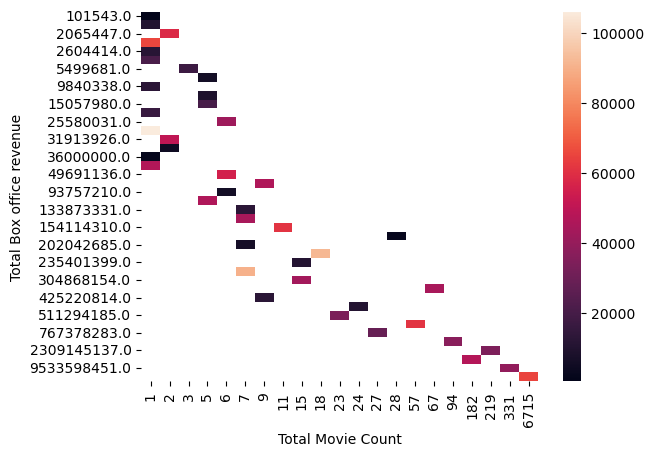

In [154]:
# HEATMAP # Nul, est-ce qu'on garde ?

df_gdp = pd.read_csv(PATH + '/GDP.csv', sep=';',)
#df_gdp = df_gdp[df_gdp['Country'].isin(focus_countries)]
df_gdp = df_gdp.rename(columns={"Country": "Movie country"})
#df_gdp['GDP per capita (constant US$)'] = pd.to_numeric(df_gdp['GDP per capita (constant US$)'], errors='coerce')

nb_per_year = df_date_revenue_clean.groupby(['Movie country', 'Movie release date']).count()['Wikipedia movie ID']
nb_per_year = nb_per_year.reset_index()
nb_per_year = nb_per_year.rename(columns={'Wikipedia movie ID': 'Movie count'})
nb_per_year['Movie release date'] = pd.to_datetime(nb_per_year['Movie release date'], errors='coerce')

total_films_per_country = nb_per_year.groupby('Movie country')['Movie count'].sum().reset_index()
total_films_per_country.columns = ['Movie country', 'Total Movie Count']
print(total_films_per_country)
df_correlation = pd.merge(df_gdp,total_films_per_country, on='Movie country')

total_revenue_per_country = df_date_revenue_clean.groupby('Movie country')['Movie box office revenue'].sum().reset_index()
total_revenue_per_country.columns = ['Movie country', 'Total Box office revenue']

df_correlation = pd.merge(df_correlation, total_revenue_per_country, on='Movie country')

df3 = pd.crosstab(
    df_correlation['Total Box office revenue'],
    df_correlation['Total Movie Count'],
    values=df_correlation['GDP per capita (constant US$)'],
    margins=False,
    aggfunc='mean'
)

sns.heatmap(df3, annot=False)

